<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [1]:
import pandas as pd
import json
import torch
import os

from skimage import io, transform
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms


from PIL import Image
import numpy as np

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Data loader

In [2]:
class PlanesDataset(Dataset):
    
    def __init__(self, annotation_file, root_dir, transform=None):
        
        with open('/home/alex/Рабочий стол/python/yandex/planes/labels.json') as json_file:
            self.annotation = json.load(json_file)
            
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
         #   idx = idx.tolist()
       
        annotation = self.annotation[idx]
        path = annotation['data']['image']
        
        image = Image.open(path)
        
        image_2_npArray = np.asarray(image)
        image = torchvision.transforms.ToTensor()(image_2_npArray)
        
        result = annotation['annotations'][0]['result']
        
        center_x = -1
        center_y = -1
        label = 0
        
        shape = image.shape
        image = self.transform(image)
        
        if len(result) > 0:
            result = result[0]
        
        
            original_width = result['original_width']
            original_height = result['original_height']

            value = result['value']
            x = (value['x'] / 100.0) * original_width
            y = (value['y'] / 100.0) * original_height

            width = (value['width'] / 100.0) * original_width
            height = (value['height'] / 100.0) * original_height

            center_x =  int(x + (width / 2) )        
            center_y = int(y + (height / 2) )



            center_x = center_x *  ( image.shape[2]/ shape[2] )
            center_y = center_y * ( image.shape[1]/ shape[1] ) 
            label = 1
        
        return {'image': image, 'xy': torch.IntTensor([center_x , center_y]), 'label' : label}


In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
transform = transforms.Compose([
    transforms.Resize((600,600))
])

In [5]:
planes_dataset = PlanesDataset(annotation_file='/home/alex/Рабочий стол/python/yandex/planes/labels.json',
                                    root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/',transform=transform)


In [6]:
def show_image(img_tensor):
    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    
    #==================================
    dpi = 80
    height, width, depth = image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(image)

    plt.show()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
<ipython-input-2-98e835f09df8>:59: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return {'image': image, 'xy': torch.IntTensor([center_x , center_y]), 'label' : label}
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for int

/home/alex/Рабочий стол/python/yandex/planes/data/1.jpg


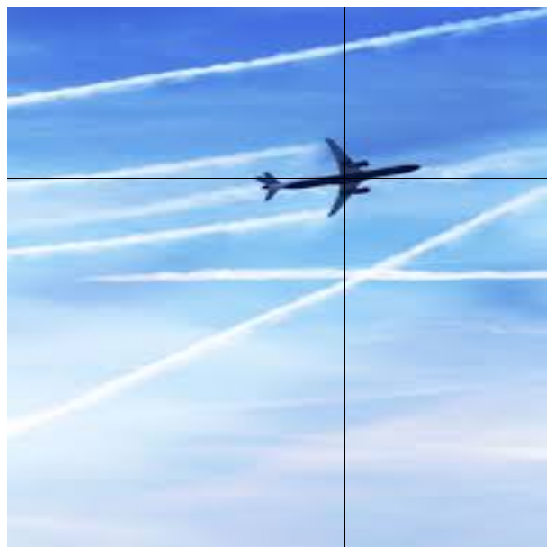

In [7]:
try:
    batch = planes_dataset[8]
    img_tensor = batch['image']
    x = batch['xy'][0]
    y = batch['xy'][1]
    for i in range(0, img_tensor.size()[2]):
        img_tensor[:, y, i] = -1

    for i in range(0, img_tensor.size()[1]):
        img_tensor[:, i, x] = -1    
    
    show_image(img_tensor)
except ValueError:
    print("Oops!  That was no valid number.  Try again...")

In [8]:
img_tensor.size()

torch.Size([3, 600, 600])

In [9]:
y

tensor(190, dtype=torch.int32)

In [10]:
x

tensor(375, dtype=torch.int32)

In [11]:
type(x)

torch.Tensor

## Network architecture

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = SimpleNet().to(device)
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)
net = net.to(device)

In [13]:
loss_function_xy = torch.nn.L1Loss()
loss_function_bce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Train

In [14]:
train_size = int(0.8 * len(planes_dataset))
test_size = len(planes_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(planes_dataset, [train_size, test_size])

In [15]:
train_loader = torch.utils.data.DataLoader(PlanesDataset(train_set, transform=transform, root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/'), batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(PlanesDataset(test_set, transform=transform, root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/'), batch_size=8, shuffle=False, num_workers=2)

# for epoch in range(10):

    net.train()
    epoch_loss = 0.

    for batch in train_loader:
        images, xy, labels = batch['image'], batch['xy'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = net(images)
        
        indexes = [i for i in range(len(labels)) if labels[i] == 1]
        
        loss = loss_function_xy(predictions[indexes, :2], xy[indexes]) 
        
        loss = loss + loss_function_bce(predictions[:, 2:], labels)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Train: {epoch_loss / len(train_loader)}')

    net.eval()
    epoch_loss = 0.

    for batch in test_loader:
        images, xy, labels = batch['image'], batch['xy'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        predictions = net(images)

        with torch.no_grad():
            indexes = [i for i in range(len(labels)) if labels[i] == 1]
            loss = loss_function_xy(predictions[indexes, :2], xy[indexes])
            loss = loss + loss_function_bce(predictions[:, 2:], labels)
        

        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(test_loader)}')

In [ ]:
predictions[indexes, :2]

In [ ]:
predictions[indexes, 2]

In [ ]:
labels